# Exercise 13:  Resampling methods

This homework assignment is designed to give you practice with bootstrapping and permutation tests.

You will need to download the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file from the *Homework/hcp_data* folder in the class GitHub repository. 

This data is a portion of the [Human Connectome Project database](http://www.humanconnectomeproject.org/). It provides measures of cognitive tasks and brain morphology measuresments from 1206 participants. The full description of each variable is provided in the **HCP_S1200_DataDictionary_April_20_2018.csv** file in the *Homework/hcp_data* folder in the class GitHub repository.

---
## 1. Loading & Visualizing the Data (1 point)

Use the `setwd` and `read.csv` functions to load data from the **unrestricted_trimmed_1_7_2020_10_50_44.csv** file. 

(a) Using the tidyverse tools, make a new dataframe `d1` that only inclues the subject ID (`Subject`), gender (`Gender`, self reported at time of data collection), Flanker Task performance (`Flanker_Unadj`), total intracranial volume (`FS_IntraCranial_Vol`), total white matter volume (`FS_Tot_WM_Vol`), and total grey matter volume (`FS_Total_GM_Vol`) variables and remove all _na_ values.

Use the `head` function to look at the first few rows of each data frame. 

In [79]:
# WRITE YOUR CODE HERE
setwd("/Users/ddbutler/Desktop/repos_new/Butler_DSPN_S24/Homework")

# If you are running this on Colab, then use something like this.
# system("gdown --id 1hywRmGdvhbDYTrQRyl1_bLJsq-T3GJq2")

# INSERT CODE HERE
library(tidyverse)
library(dplyr)

#make new dataframe
d1 <- read.csv('hcp_data/unrestricted_trimmed_1_7_2020_10_50_44.csv') %>%
    #include Subject, Gender, FS_Tot_WM_Vol, FS_IntraCranial_Vol
    select(Subject, Gender, Flanker_Unadj, FS_IntraCranial_Vol, FS_Tot_WM_Vol, FS_Total_GM_Vol) %>%
    drop_na()

head(d1)


,Subject,Gender,Flanker_Unadj,FS_IntraCranial_Vol,FS_Tot_WM_Vol,FS_Total_GM_Vol
,<int>,<chr>,<dbl>,<dbl>,<int>,<int>
1,100206,M,130.42,1864518,543134,807245
2,100307,F,112.56,1512540,407292,664124
3,100408,M,121.18,1684117,500417,726206
4,100610,M,126.53,1816044,512946,762308
5,101006,F,101.85,1437868,429449,579632
6,101107,M,107.04,1512727,416995,665024


(b) Plot grey matter volume (x axis) against intracranial volume (y axis) and Gender (point color). 

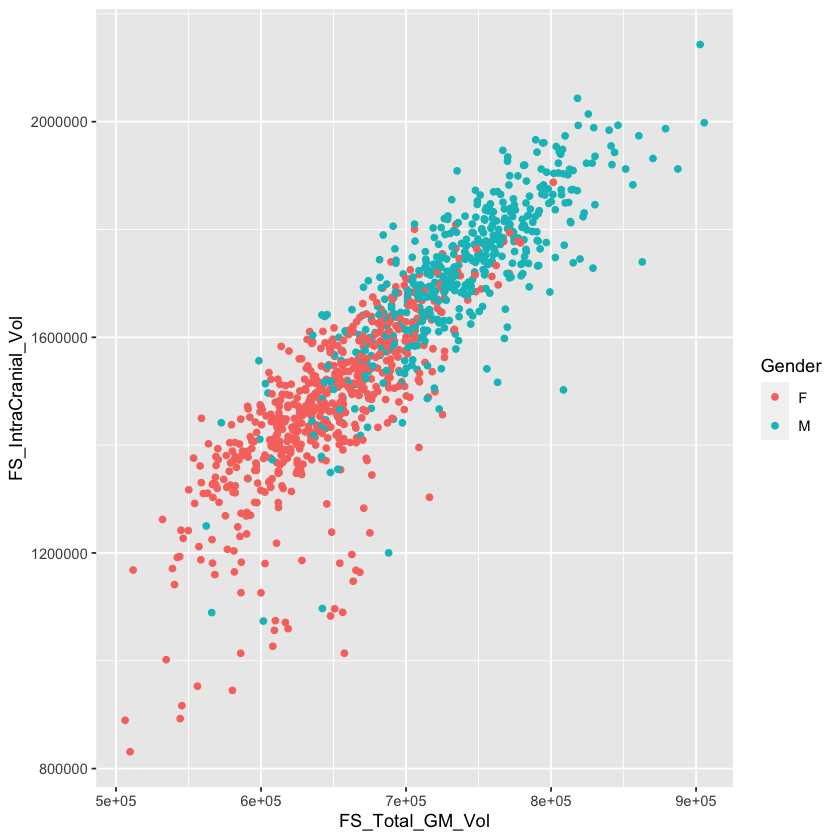

In [80]:
# WRITE YOUR CODE HERE
ggplot(d1, aes(x=FS_Total_GM_Vol,y=FS_IntraCranial_Vol, color=Gender)) + 
    geom_point()


What patterns do you observe in the scatter plot?

> *Write your response here* 
> Male identifying subjects tend to have higher grey matter and cranial volume. There seems to be a positive relationship between grey matter volume and intracranial volume

---
## 2. Logistic classifier (2 points)

We want to try predicting gender using the neural data you have loaded.

(a) Run a logisic regression model to predict gender from total white matter volume, total grey matter volume, and intracranial volume. 

In [81]:
d1$Gender <- factor(d1$Gender)
levels(d1$Gender)

[1] "F" "M"

In [82]:
# WRITE YOUR CODE HERE
# Train logistic regression model with total white matter volume, total grey matter colume
# and intercranial volume 
glm.fit = glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, data=d1, family=binomial)
summary(glm.fit)


Call:
glm(formula = Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, 
    family = binomial, data = d1)

Coefficients:
                      Estimate Std. Error z value Pr(>|z|)    
(Intercept)         -2.262e+01  1.347e+00 -16.787  < 2e-16 ***
FS_Tot_WM_Vol        2.140e-06  3.059e-06   0.699    0.484    
FS_Total_GM_Vol      1.959e-05  3.145e-06   6.229 4.70e-10 ***
FS_IntraCranial_Vol  5.020e-06  1.177e-06   4.263 2.01e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 1534.13  on 1112  degrees of freedom
Residual deviance:  919.85  on 1109  degrees of freedom
AIC: 927.85

Number of Fisher Scoring iterations: 5


Which factors are signficantly associated with gender?

> *Write your response here* 

>  FS_Total_GM_Vol (grey matter volume), FS_IntraCranial_Vol (intercranial volume)

(b) Estimate the prediction accuracy of your model (Note: this is the training set accuracy). Set your prediction threshold to 0.5.

In [83]:
# WRITE YOUR CODE HERE
# Get theprediction probabilities
glm.probs=predict(glm.fit, d1, type="response")

# Initialize predicition dataframe
glm.pred=rep("F", nrow(d1)) 
glm.pred[glm.probs>0.5]="M" #binarize the result

head(glm.pred)
confusion_df = data.frame(glm.pred, d1$Gender) #create confusion df
colnames(confusion_df) = c('predicted', 'actual')

# Show the confusion matrix
table(confusion_df)

estimated_acc = mean(confusion_df$predicted == confusion_df$actual)
# Show accuracy
print(paste("Accuracy:", mean(confusion_df$predicted == confusion_df$actual)))


[1] "M" "F" "M" "M" "F" "F"

         actual
predicted   F   M
        F 516 110
        M  90 397

[1] "Accuracy: 0.820305480682839"


What is the prediction accuracy for gender from the full model?

>*Write your response here* 
> Accuracy is 0.82.

---
## 3. Bootstrapped accuracy (3 points)

Use bootstrapping to estimate the confidence intervals of the _prediction accuracy_ of your model (i.e., the confidence of the correlation between $\hat{y}$ and $y$). Plot the histogram of the bootstrapped prediction accuracies and estimate the confidence intervals off of the standard deviation from the bootstrap.


In [84]:
# WRITE YOUR CODE HERE
library(boot)

# The function needs two inputs: Data, Index
boot.fn <- function(d1, index){  
    # return: throw this as output
    # accuracy
    #train model
    glm.fit = glm(Gender ~ FS_Tot_WM_Vol + FS_Total_GM_Vol + FS_IntraCranial_Vol, 
    data=d1, family=binomial, subset = index)

    # Get the prediction probabilities
    glm.probs= predict(glm.fit, d1, type="response")

    # Initialize predicition dataframe
    glm.pred=rep("F", nrow(d1)) 
    glm.pred[glm.probs>0.5]= "M" #binarize the result

    #head(glm.pred)
    confusion_df = data.frame(glm.pred, d1$Gender) #create confusion df
    colnames(confusion_df) = c('predicted', 'actual')

    #return accuracy
    return( mean(confusion_df$predicted == confusion_df$actual))
}

#data, boot function with estimates, number of repetitions. 
boot_obj = boot(d1,boot.fn ,R=1000) #R=repetitions 
print(boot_obj) #t1 is the intercept and t2 is the horsepower coeff.





ORDINARY NONPARAMETRIC BOOTSTRAP


Call:
boot(data = d1, statistic = boot.fn, R = 1000)


Bootstrap Statistics :
     original       bias    std. error
t1* 0.8203055 -0.002259659  0.00453967


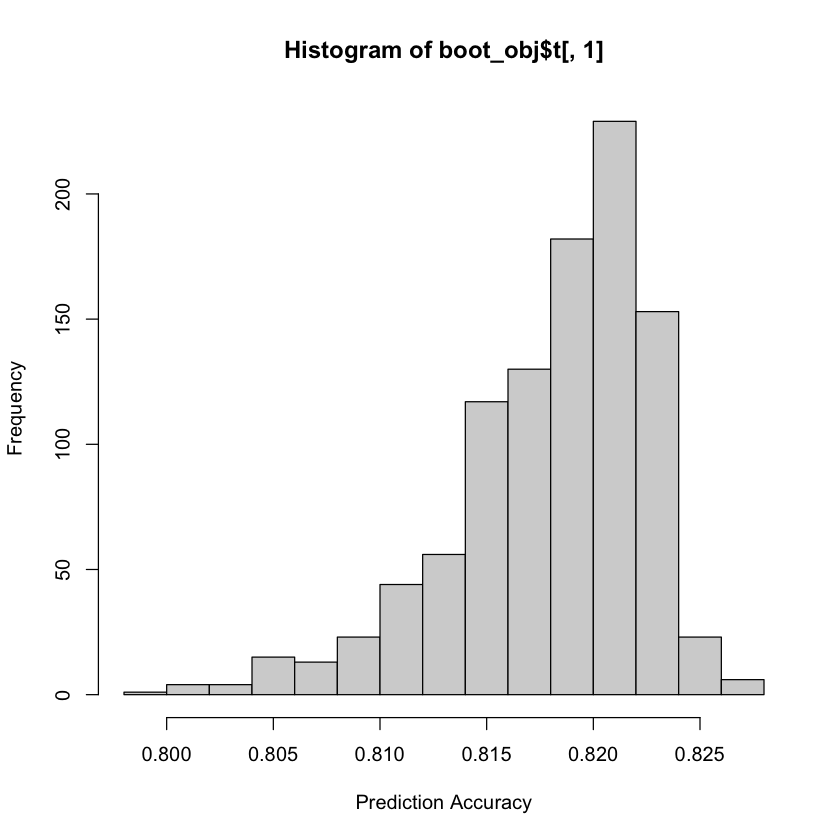

In [85]:

hist(boot_obj$t[,1], xlab="Prediction Accuracy") #we get a distribution of all of the estimates
#                               ^^ indexing the second "t" value

How robust is the prediction accuracy of the full model?

> *Write your response here* 

> The Accuracy has a small standard error of 0.0047 so the accuracy is robust.

In [86]:
#sense check
print(boot.fn(d1, 1:nrow(d1)))

[1] 0.8203055


---
## 4. Permutation test for grey matter effects (3 points)

Now run a permutation test, with 1000 iterations, to evaluate how much grey matter volume contributes to the prediction accuracy. Compare the prediction accuracy of the full (unpermuted model) with the distribution of accuracies you get with a randomized grey matter volume term using a histogram (Hint: use the `abline` function to show the original accuracy on the histogram).

NA
NA
NA
NA
NA
NA


0.8041330
0.8050314
0.8131177
0.8086253
0.8050314
0.8149146


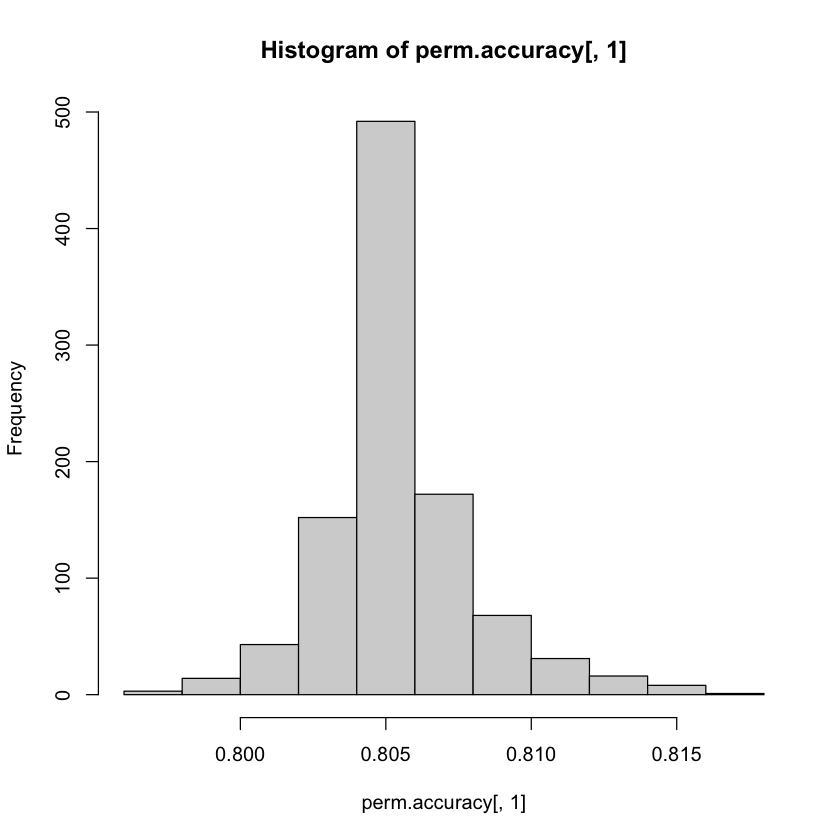

In [96]:
# WRITE YOUR CODE HERE
# First let's make a copy of the data set that we'll keep permuting
perm = d1 #want to preserve the non-permuted, true form of data!

# Set the number of iterations
R=1000

# Next smake an output object to store the results
#MATRIX OF Intercepts and Horsepower Coefficients
perm.accuracy=matrix(NA,nrow=R, ncol=1) #filling with nas at first, gives matrix, no column names
head(perm.accuracy)

# Now just write a for loop where we scramble the observations
# in X using the sample() function. We'll scramble the observations in R different ways

for (i in 1:R){
  # Shuffle the gray matter volume
  perm$FS_Total_GM_Vol=d1$FS_Total_GM_Vol[sample(nrow(perm))] 
  #perform a regression, then get the coeficients with the sample
  perm.accuracy[i] = boot.fn(perm, 1:nrow(perm)) # then we get coefficients for linear model of shuffled horsepower to auto,

}

# Take a look at the null distributions
hist(perm.accuracy[,1])
# draw vertical line at estiamted parameterized accuracy
abline(v = estimated_acc, lwd = 10, lty = "dashed" )
head(perm.accuracy)



In [98]:
perm.p = sum(perm.accuracy[, 1] < estimated_acc)/R 
perm.p

[1] 1

How much does the grey matter volume influence the prediction accuracy of the model?

> *Write your response here* 
> Grey matter does not have a strong influence on the prediction accuracy becuase there is a high probabilty of observing an accuracy higher than the real accuracy 0.82. 

---
## 5. Reflection (1 point)

Differentiate the bootstrap from a permutation test. Describe each and when is it appropriate to each.

> *Write your response here* 
> Boostrap can give you a convidence interval of specific estimates derived from you data. In constrast, permutation tests derive the null hypothesis distribution from your data.

**DUE:** 5pm EST, March 27, 2024

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Someone's Name*